# Analyse de Cohortes

## Objectifs

1. Créer les cohortes d'acquisition à partir du fichier de transactions nettoyé.
2. Calculer :
   - le nombre de clients par cohorte et par âge (M+0, M+1, …)
   - le revenu par cohorte et par âge
   - les taux de rétention
3. Visualiser :
   - Heatmap de rétention  
   - Heatmap du chiffre d'affaires par âge  
   - Courbe de densité de valeur
4. Exporter :
   - cohort_counts.csv
   - cohort_revenue.csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Charger le fichier nettoyé
df = pd.read_excel("clean_data/transactions_excluding_returns.xlsx")

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,__source_sheet,UnitPrice,is_cancel,Amount,is_qty_outlier,is_price_outlier,is_outlier
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Year 2009-2010,0,False,0,False,False,False
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Year 2009-2010,0,False,0,False,False,False
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Year 2009-2010,0,False,0,False,False,False
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Year 2009-2010,0,False,0,False,False,False
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Year 2009-2010,0,False,0,False,False,False


## Verification des donnees

In [4]:
# On garde uniquement les lignes avec un client connu
df = df.dropna(subset=["Customer ID"]).copy()

# Conversion de la date
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Mois de facture
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M")

# Mois d'acquisition du client = premier mois de commande
df["AcqMonth"] = df.groupby("Customer ID")["InvoiceMonth"].transform("min")

# Age de cohorte en mois (M+0, M+1, ...)
df["CohortAge"] = (
    (df["InvoiceMonth"].dt.year - df["AcqMonth"].dt.year) * 12
    + (df["InvoiceMonth"].dt.month - df["AcqMonth"].dt.month)
)

df[["Customer ID", "InvoiceDate", "InvoiceMonth", "AcqMonth", "CohortAge"]].head()


,Customer ID,InvoiceDate,InvoiceMonth,AcqMonth,CohortAge
0,13085.0,2009-12-01 07:45:00,2009-12,2009-12,0
1,13085.0,2009-12-01 07:45:00,2009-12,2009-12,0
2,13085.0,2009-12-01 07:45:00,2009-12,2009-12,0
3,13085.0,2009-12-01 07:45:00,2009-12,2009-12,0
4,13085.0,2009-12-01 07:45:00,2009-12,2009-12,0


## Definition : CohortAge

In [7]:
cohort_counts = (
    df.groupby(["AcqMonth", "CohortAge"])["Customer ID"]
      .nunique()
      .unstack()
      .fillna(0)
      .astype(int)
)

# Sauvegarde
cohort_counts.to_csv("data/cohort_counts.csv")

cohort_counts.head()


CohortAge,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
AcqMonth,,,,,,,,,,,,,,,,,,,,,
2009-12,1045,392,358,447,410,408,408,374,355,392,...,319,273,316,303,287,274,332,319,427,218
2010-01,386,85,119,119,110,115,105,91,114,133,...,60,86,74,69,73,93,72,88,29,0
2010-02,364,109,83,110,93,76,79,103,100,106,...,74,67,61,53,85,90,62,23,0,0
2010-03,436,95,113,103,100,87,105,130,126,50,...,74,76,69,74,89,93,33,0,0,0
2010-04,291,67,58,47,54,67,79,76,33,34,...,43,41,41,50,61,19,0,0,0,0


## Matrice des cohortes (nombre de clients)

In [8]:
# Chiffre d'affaires ligne a ligne
df["Amount"] = df["Quantity"] * df["Price"]

cohort_revenue = (
    df.groupby(["AcqMonth", "CohortAge"])["Amount"]
      .sum()
      .unstack()
      .fillna(0.0)
)

# Sauvegarde 
cohort_revenue.to_csv("data/cohort_revenue.csv")

cohort_revenue.head()


CohortAge,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
AcqMonth,,,,,,,,,,,,,,,,,,,,,
2009-12,660024.190,380102.761,293011.432,386591.450,303720.87,290558.19,306821.95,315550.29,335062.710,371398.89,...,256232.51,163382.041,280778.15,288507.73,251608.67,264055.11,385502.82,404441.18,458093.35,164196.87
2010-01,149512.901,37300.761,50615.750,55178.381,52014.67,55633.89,43299.21,42812.00,53001.991,68575.31,...,27420.25,41225.020,31630.06,42998.61,35575.17,52474.21,54142.18,45804.90,6374.84,0.00
2010-02,157230.753,29655.560,49757.320,47695.470,40362.23,36333.25,36606.94,45501.77,50618.510,52849.34,...,36463.91,27878.040,31145.24,23177.39,42060.52,42598.94,34526.17,11025.69,0.00,0.00
2010-03,167216.211,45316.500,45213.130,51426.010,44119.34,48795.00,58321.06,72586.79,67307.650,20086.68,...,29581.08,34090.020,46662.06,43750.24,51988.13,57231.72,15686.41,0.00,0.00,0.00
2010-04,103828.861,15769.400,18022.520,25782.210,20488.61,30756.83,31489.05,27194.27,8966.560,16962.26,...,19455.41,17086.810,17566.67,23154.54,25078.22,4366.13,0.00,0.00,0.00,0.00


## Matrice des cohortes (revenu)

In [9]:
# On divise chaque ligne par M+0 (effectif initial de la cohorte)
base = cohort_counts[0].replace(0, np.nan)
retention = cohort_counts.divide(base, axis=0)

# On arrondit 
retention = retention.round(3)

retention.head()


CohortAge,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
AcqMonth,,,,,,,,,,,,,,,,,,,,,
2009-12,1.0,0.375,0.343,0.428,0.392,0.390,0.390,0.358,0.340,0.375,...,0.305,0.261,0.302,0.290,0.275,0.262,0.318,0.305,0.409,0.209
2010-01,1.0,0.220,0.308,0.308,0.285,0.298,0.272,0.236,0.295,0.345,...,0.155,0.223,0.192,0.179,0.189,0.241,0.187,0.228,0.075,0.000
2010-02,1.0,0.299,0.228,0.302,0.255,0.209,0.217,0.283,0.275,0.291,...,0.203,0.184,0.168,0.146,0.234,0.247,0.170,0.063,0.000,0.000
2010-03,1.0,0.218,0.259,0.236,0.229,0.200,0.241,0.298,0.289,0.115,...,0.170,0.174,0.158,0.170,0.204,0.213,0.076,0.000,0.000,0.000
2010-04,1.0,0.230,0.199,0.162,0.186,0.230,0.271,0.261,0.113,0.117,...,0.148,0.141,0.141,0.172,0.210,0.065,0.000,0.000,0.000,0.000


## Definition : taux de retention

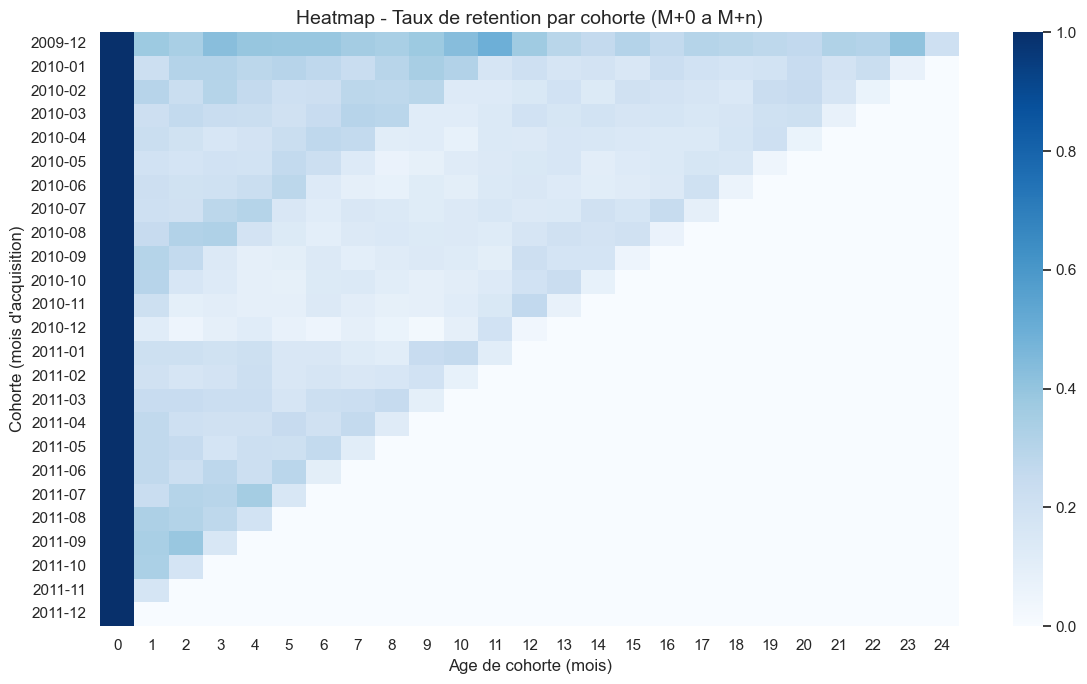

In [10]:
plt.figure(figsize=(12, 7))
sns.heatmap(retention, cmap="Blues", annot=False)
plt.title("Heatmap - Taux de retention par cohorte (M+0 a M+n)", fontsize=14)
plt.ylabel("Cohorte (mois d'acquisition)")
plt.xlabel("Age de cohorte (mois)")
plt.tight_layout()
plt.savefig("docs/cohort_retention_heatmap.png", dpi=150)
plt.show()


## Analyse de la retention (a completer)

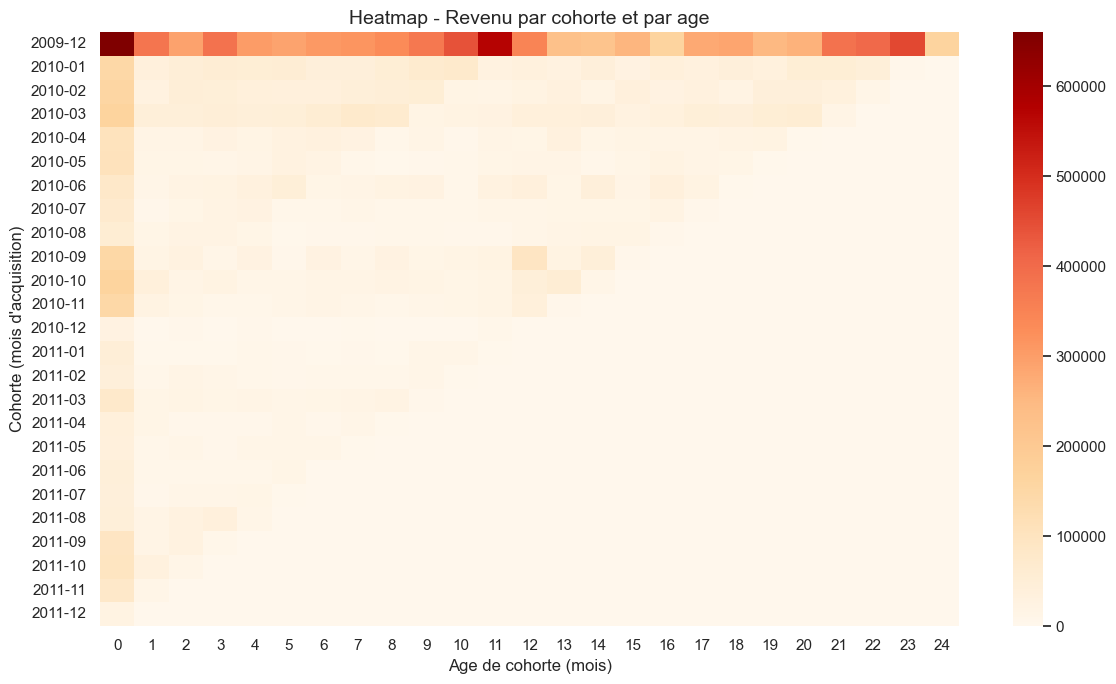

In [11]:
plt.figure(figsize=(12, 7))
sns.heatmap(cohort_revenue, cmap="OrRd", annot=False)
plt.title("Heatmap - Revenu par cohorte et par age", fontsize=14)
plt.ylabel("Cohorte (mois d'acquisition)")
plt.xlabel("Age de cohorte (mois)")
plt.tight_layout()
plt.savefig("docs/cohort_revenue_heatmap.png", dpi=150)
plt.show()


## Analyse du revenu par age de cohorte

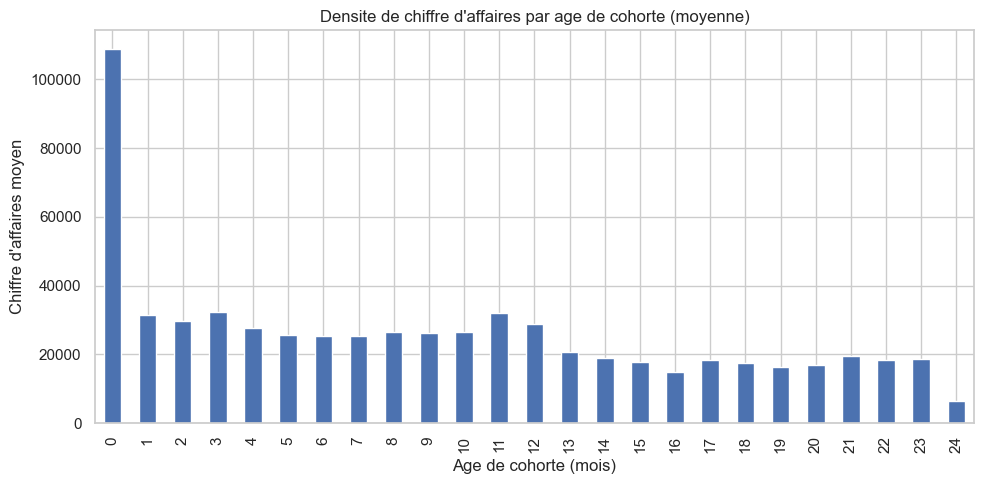

In [12]:
age_revenue = cohort_revenue.mean()

plt.figure(figsize=(10, 5))
age_revenue.plot(kind="bar")
plt.title("Densite de chiffre d'affaires par age de cohorte (moyenne)")
plt.ylabel("Chiffre d'affaires moyen")
plt.xlabel("Age de cohorte (mois)")
plt.tight_layout()
plt.savefig("docs/age_revenue_density.png", dpi=150)
plt.show()


## Interpretation de la densite de valeur

La courbe precedente montre le chiffre d'affaires moyen genere a chaque age de cohorte.